In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#### Market Exploration

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



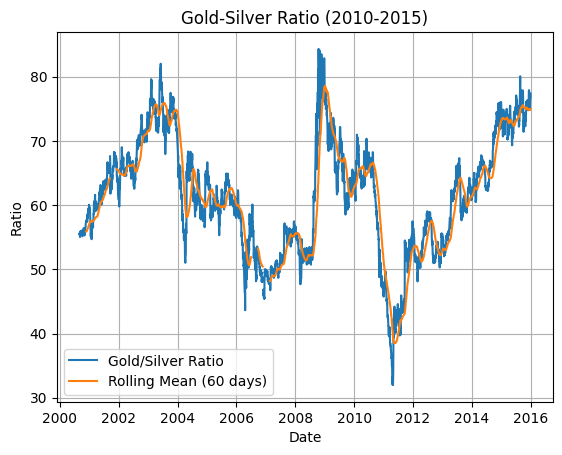

In [64]:
from scipy.optimize import minimize_scalar

# Training data: 2010-01-01 to 2015-12-31
historical_gold = yf.download('GC=F', start='2000-01-01', end='2015-12-31', auto_adjust=False)
historical_silver = yf.download('SI=F', start='2000-01-01', end='2015-12-31', auto_adjust=False)

#plt.plot(gold.index, gold['Close'], label='Gold')
#plt.plot(silver.index, silver['Close'], label='Silver')

historical_ratio = historical_gold[('Close', 'GC=F')] / historical_silver[('Close', 'SI=F')]
plt.plot(historical_ratio.index, historical_ratio, label='Gold/Silver Ratio')

rolling_window = 60 # You can change this value as needed

rolling_mean = historical_ratio.rolling(window=rolling_window).mean() 

plt.plot(rolling_mean.index, rolling_mean, label=f'Rolling Mean ({rolling_window} days)')
plt.legend()
plt.title('Gold-Silver Ratio (2010-2015)')
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.grid(True) 

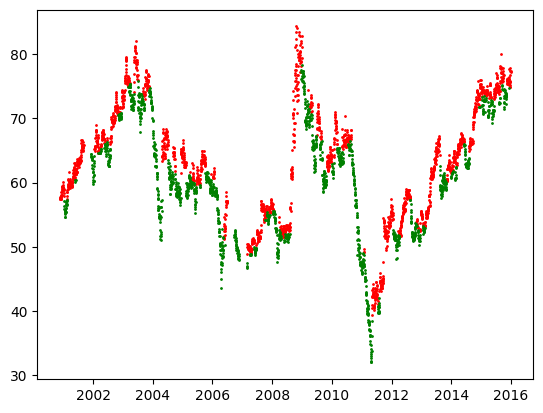

In [66]:
mask = ~rolling_mean.isna()
above_mean = (historical_ratio > rolling_mean.shift(-1)) & mask
below_mean = (historical_ratio <= rolling_mean.shift(-1)) & mask

plt.scatter(historical_ratio.index[above_mean], historical_ratio[above_mean], color='r', s=1)
plt.scatter(historical_ratio.index[below_mean], historical_ratio[below_mean], color='g', s=1)

C:\Users\yuqua\AppData\Local\Temp\ipykernel_27684\2990908860.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_historical = yf.download('GC=F', start='2010-01-01', end='2015-12-31')
[*********************100%***********************]  1 of 1 completed


C:\Users\yuqua\AppData\Local\Temp\ipykernel_27684\2990908860.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  silver_historical = yf.download('SI=F', start='2015-01-01', end='2015-12-31')
[*********************100%***********************]  1 of 1 completed
C:\Users\yuqua\AppData\Local\Temp\ipykernel_27684\2990908860.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_2016 = yf.download('GC=F', start='2016-01-01', end='2016-12-31')
[*********************100%***********************]  1 of 1 completed
C:\Users\yuqua\AppData\Local\Temp\ipykernel_27684\2990908860.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_2016 = yf.download('GC=F', start='2016-01-01', end='2016-12-31')
[*********************100%***********************]  1 of 1 completed
C:\Users\yuqua\AppData\Local\Temp\ipykernel_27684\2990908860.py:11: FutureWarning: YF.download() has changed argument auto_adjust d

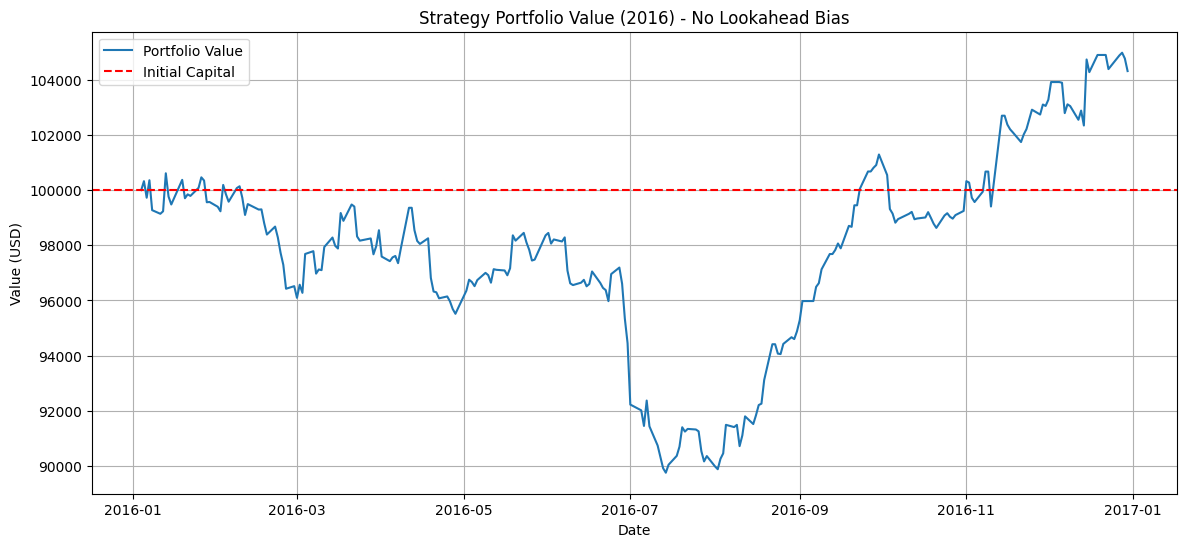

Final Portfolio Value: $104,314.85
Total Profit: $4,314.85


In [82]:
# Compute rolling mean and std using only past data (exclude current day)

window = 200

# Download BOTH historical data (2015 for training) AND 2016 data (for trading)
# We need 2015 data to compute initial statistics before trading in 2016
gold_historical = yf.download('GC=F', start='2010-01-01', end='2015-12-31')
silver_historical = yf.download('SI=F', start='2015-01-01', end='2015-12-31')

gold_2016 = yf.download('GC=F', start='2016-01-01', end='2016-12-31')
silver_2016 = yf.download('SI=F', start='2016-01-01', end='2016-12-31')

# Compute historical ratio
ratio_historical = gold_historical[('Close', 'GC=F')] / silver_historical[('Close', 'SI=F')]
ratio_2016 = gold_2016[('Close', 'GC=F')] / silver_2016[('Close', 'SI=F')]

# Strategy parameters
z_entry = 0.2
z_exit = 0.2

initial_capital = 100000

# Prepare tracking variables
dates_2016 = ratio_2016.index
gold_close_2016 = gold_2016[('Close', 'GC=F')]
silver_close_2016 = silver_2016[('Close', 'SI=F')]

position_gold = pd.Series(0.0, index=dates_2016)
position_silver = pd.Series(0.0, index=dates_2016)
cash = pd.Series(initial_capital, index=dates_2016)
portfolio_value = pd.Series(initial_capital, index=dates_2016)
zscore_2016 = pd.Series(0.0, index=dates_2016)

in_position = False
entry_side = None

rolling_mean_list = []

for i in range(len(dates_2016)):
    date = dates_2016[i]
    
    # At each day, combine ALL past data (historical + 2016 up to yesterday)
    if i == 0:
        past_ratios = ratio_historical
    elif i < rolling_window:
        past_ratios = pd.concat([ratio_historical[-(rolling_window-1):], ratio_2016.iloc[:i]])
    else:
        past_ratios = ratio_2016[i - rolling_window:i]
    
    # Calculate rolling mean and std using only past data
    rolling_mean = past_ratios.rolling(window=window, min_periods=1).mean().iloc[-1]
    rolling_mean_list.append(rolling_mean)
    rolling_std = past_ratios.rolling(window=window, min_periods=1).std().iloc[-1]
    
    # Calculate z-score for today
    zscore_2016.iloc[i] = (ratio_2016.iloc[i] - rolling_mean) / rolling_std
    
    if i > 0:
        # Carry forward previous positions
        position_gold.iloc[i] = position_gold.iloc[i-1]
        position_silver.iloc[i] = position_silver.iloc[i-1]
        cash.iloc[i] = cash.iloc[i-1]
    
    # Update portfolio value
    portfolio_value.iloc[i] = (cash.iloc[i] +
                               position_gold.iloc[i] * gold_close_2016.iloc[i] +
                               position_silver.iloc[i] * silver_close_2016.iloc[i])
    
    if not in_position:
        if zscore_2016.iloc[i] > z_entry:
            # Short gold, long silver
            gold_value = -0.5 * portfolio_value.iloc[i]
            silver_value = 0.5 * portfolio_value.iloc[i]
            position_gold.iloc[i] = gold_value / gold_close_2016.iloc[i]
            position_silver.iloc[i] = silver_value / silver_close_2016.iloc[i]
            in_position = True
            entry_side = 'short_gold'
        elif zscore_2016.iloc[i] < -z_entry:
            # Long gold, short silver
            gold_value = 0.5 * portfolio_value.iloc[i]
            silver_value = -0.5 * portfolio_value.iloc[i]
            position_gold.iloc[i] = gold_value / gold_close_2016.iloc[i]
            position_silver.iloc[i] = silver_value / silver_close_2016.iloc[i]
            in_position = True
            entry_side = 'long_gold'
    else:
        # Exit condition: z-score crosses mean
        if (entry_side == 'long_gold' and zscore_2016.iloc[i] > z_exit) or \
           (entry_side == 'short_gold' and zscore_2016.iloc[i] < -z_exit):
            # Close positions
            cash.iloc[i] = (cash.iloc[i] +
                            position_gold.iloc[i] * gold_close_2016.iloc[i] +
                            position_silver.iloc[i] * silver_close_2016.iloc[i])
            position_gold.iloc[i] = 0
            position_silver.iloc[i] = 0
            in_position = False
            entry_side = None

# Calculate daily returns and cumulative profit
daily_pnl_2016 = portfolio_value.diff().fillna(0)
cumulative_profit_2016 = portfolio_value - initial_capital

# Plot results
plt.figure(figsize=(14, 6))
plt.plot(portfolio_value.index, portfolio_value, label='Portfolio Value')
plt.axhline(initial_capital, color='r', linestyle='--', label='Initial Capital')
plt.title('Strategy Portfolio Value (2016) - No Lookahead Bias')
plt.xlabel('Date')
plt.ylabel('Value (USD)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final Portfolio Value: ${portfolio_value.iloc[-1]:,.2f}")
print(f"Total Profit: ${cumulative_profit_2016.iloc[-1]:,.2f}")

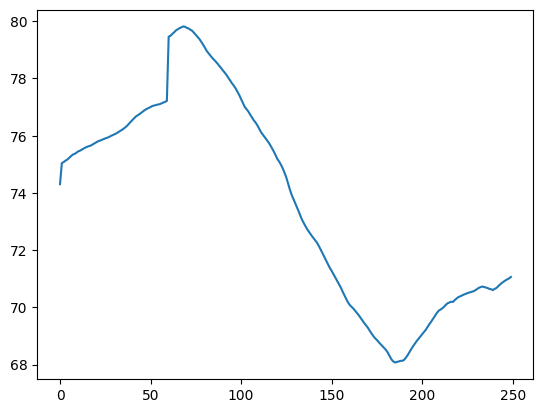

In [78]:
plt.plot(rolling_mean_list)

#### Moving Average Reversion

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\yuqua\AppData\Local\Temp\ipykernel_27684\1219779905.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_new = yf.download('GC=F', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\yuqua\AppData\Local\Temp\ipykernel_27684\1219779905.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_new = yf.download('GC=F', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\yuqua\AppData\Local\Temp\ipykernel_27684\1219779905.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  silver_new = yf.download('SI=F', start=start_date, end=end_date)
[*******************

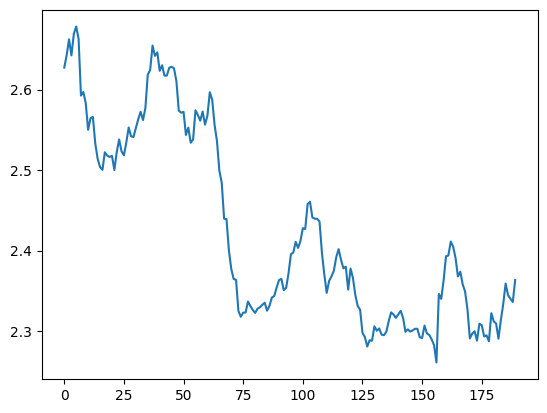

In [62]:
start_date = '2016-01-01'
end_date = '2016-12-31'

# Training data: 2010-01-01 to 2015-12-31
historical_gold = yf.download('GC=F', start='2000-01-01', end='2015-12-31', auto_adjust=False)
historical_silver = yf.download('SI=F', start='2000-01-01', end='2015-12-31', auto_adjust=False)

historical_ratio = historical_gold[('Close', 'GC=F')] / historical_silver[('Close', 'SI=F')]
#plt.plot(historical_ratio.index, historical_ratio, label='Gold/Silver Ratio')

rolling_window = 60 # You can change this value as needed

rolling_mean = historical_ratio.rolling(window=rolling_window).mean() 

# Backtesting data
gold_new = yf.download('GC=F', start=start_date, end=end_date)
silver_new = yf.download('SI=F', start=start_date, end=end_date)
#ratio_2016 = gold_2016[('Close', 'GC=F')] / silver_2016[('Close', 'SI=F')]
#current_ratio = historical_ratio.iloc[-1]

# To start, just trade on the new data set first (i.e. start with rolling window)
ratio_list = []

for i in range(rolling_window, len(gold_new)):
    current_ratio = 0
    for j in (i-rolling_window, i):
        current_ratio += (gold_new[('Close', 'GC=F')].iloc[j] / silver_new[('Close', 'SI=F')].iloc[j]) / rolling_window
    ratio_list.append(current_ratio)
plt.plot(ratio_list, label='Current Ratio')




#### Fit first - then trade difference

C:\Users\yuqua\AppData\Local\Temp\ipykernel_2832\3540974871.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold = yf.download('GC=F', start='2010-01-01', end='2015-12-31')
[*********************100%***********************]  1 of 1 completed
C:\Users\yuqua\AppData\Local\Temp\ipykernel_2832\3540974871.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  silver = yf.download('SI=F', start='2010-01-01', end='2015-12-31')
[*********************100%***********************]  1 of 1 completed


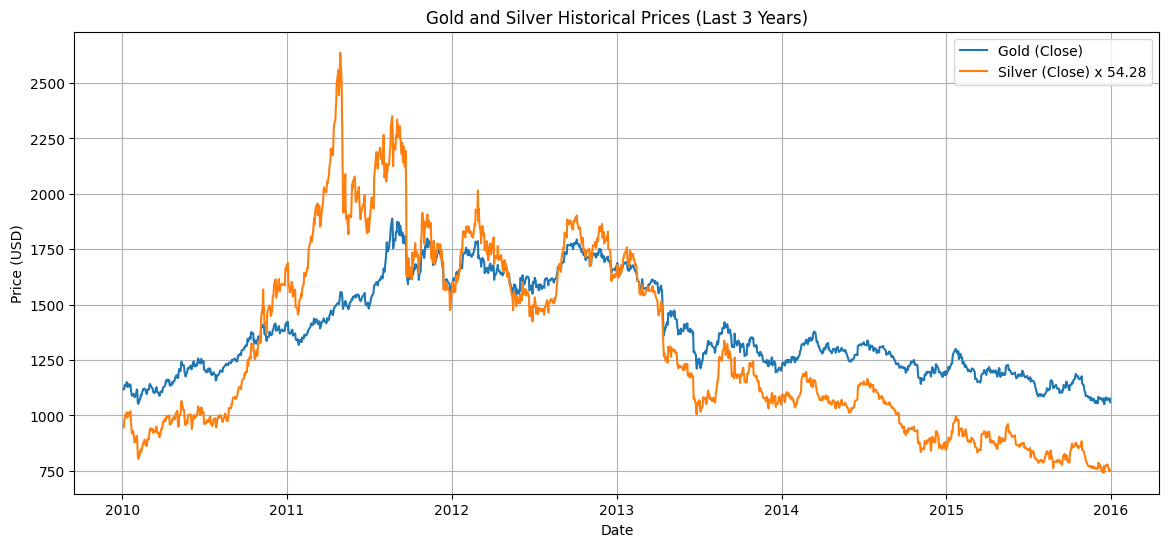

In [4]:
from scipy.optimize import minimize_scalar

# Training data: 2010-01-01 to 2015-12-31
gold = yf.download('GC=F', start='2010-01-01', end='2015-12-31')
silver = yf.download('SI=F', start='2010-01-01', end='2015-12-31')

plt.figure(figsize=(14, 6))
plt.plot(gold.index, gold[('Close', 'GC=F')], label='Gold (Close)')

# Find k that minimizes the sum of squared differences between gold and silver*k
def objective(k):
    return np.sum((gold[('Close', 'GC=F')] - silver[('Close', 'SI=F')]*k)**2)

res = minimize_scalar(objective)
k = res.x

plt.plot(silver.index, silver[('Close', 'SI=F')]*k, label='Silver (Close) x {:.2f}'.format(k))
plt.title('Gold and Silver Historical Prices (Training Period)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal hedge ratio (k): {k:.4f}")


Training Spread Mean: 71.37
Training Spread Std: 245.26


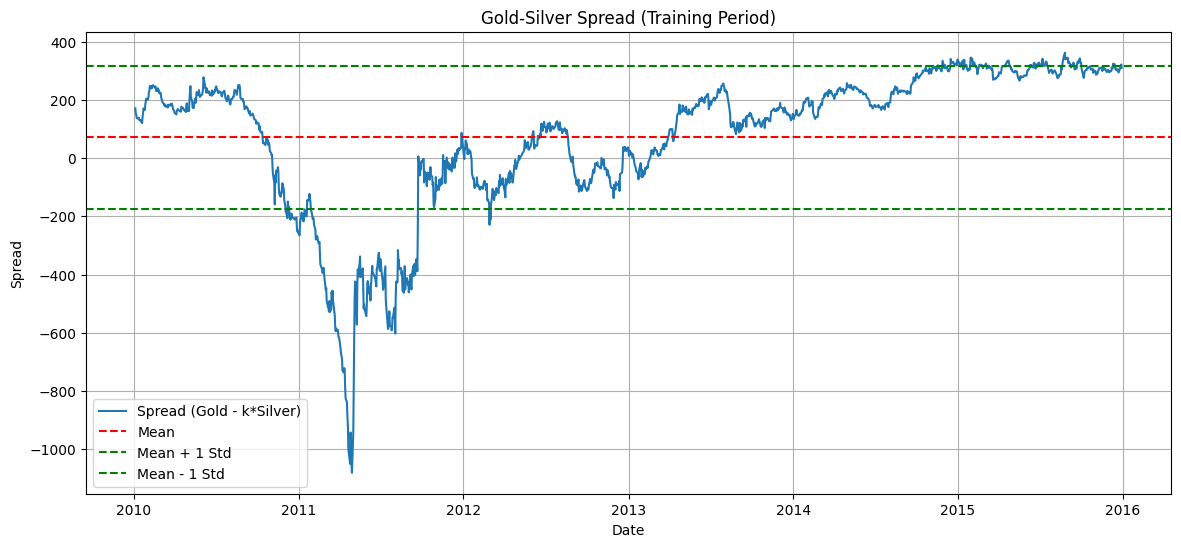

In [6]:
# Calculate spread statistics from training data
spread = gold[('Close', 'GC=F')] - silver[('Close', 'SI=F')]*k  
spread_mean = spread.mean()
spread_std = spread.std()

print(f"Training Spread Mean: {spread_mean:.2f}")
print(f"Training Spread Std: {spread_std:.2f}")

# Plot the spread
plt.figure(figsize=(14, 6))
plt.plot(spread.index, spread, label='Spread (Gold - k*Silver)')
plt.axhline(y=spread_mean, color='r', linestyle='--', label='Mean')
plt.axhline(y=spread_mean + spread_std, color='g', linestyle='--', label='Mean + 1 Std')
plt.axhline(y=spread_mean - spread_std, color='g', linestyle='--', label='Mean - 1 Std')
plt.title('Gold-Silver Spread (Training Period)')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\yuqua\AppData\Local\Temp\ipykernel_2832\1694091532.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold_test = yf.download('GC=F', start='2017-01-01', end='2017-06-30')
[*********************100%***********************]  1 of 1 completed
C:\Users\yuqua\AppData\Local\Temp\ipykernel_2832\1694091532.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  silver_test = yf.download('SI=F', start='2017-01-01', end='2017-06-30')
[*********************100%***********************]  1 of 1 completed
C:\Users\yuqua\AppData\Local\Temp\ipykernel_2832\1694091532.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  silver_test = yf.download('SI=F', start='2017-01-01', end='2017-06-30')
[*********************100%***********************]  1 of 1 completed
C:\Users\yuqua\AppData\Local\Temp\ipykernel_2832\1694091532.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and wil

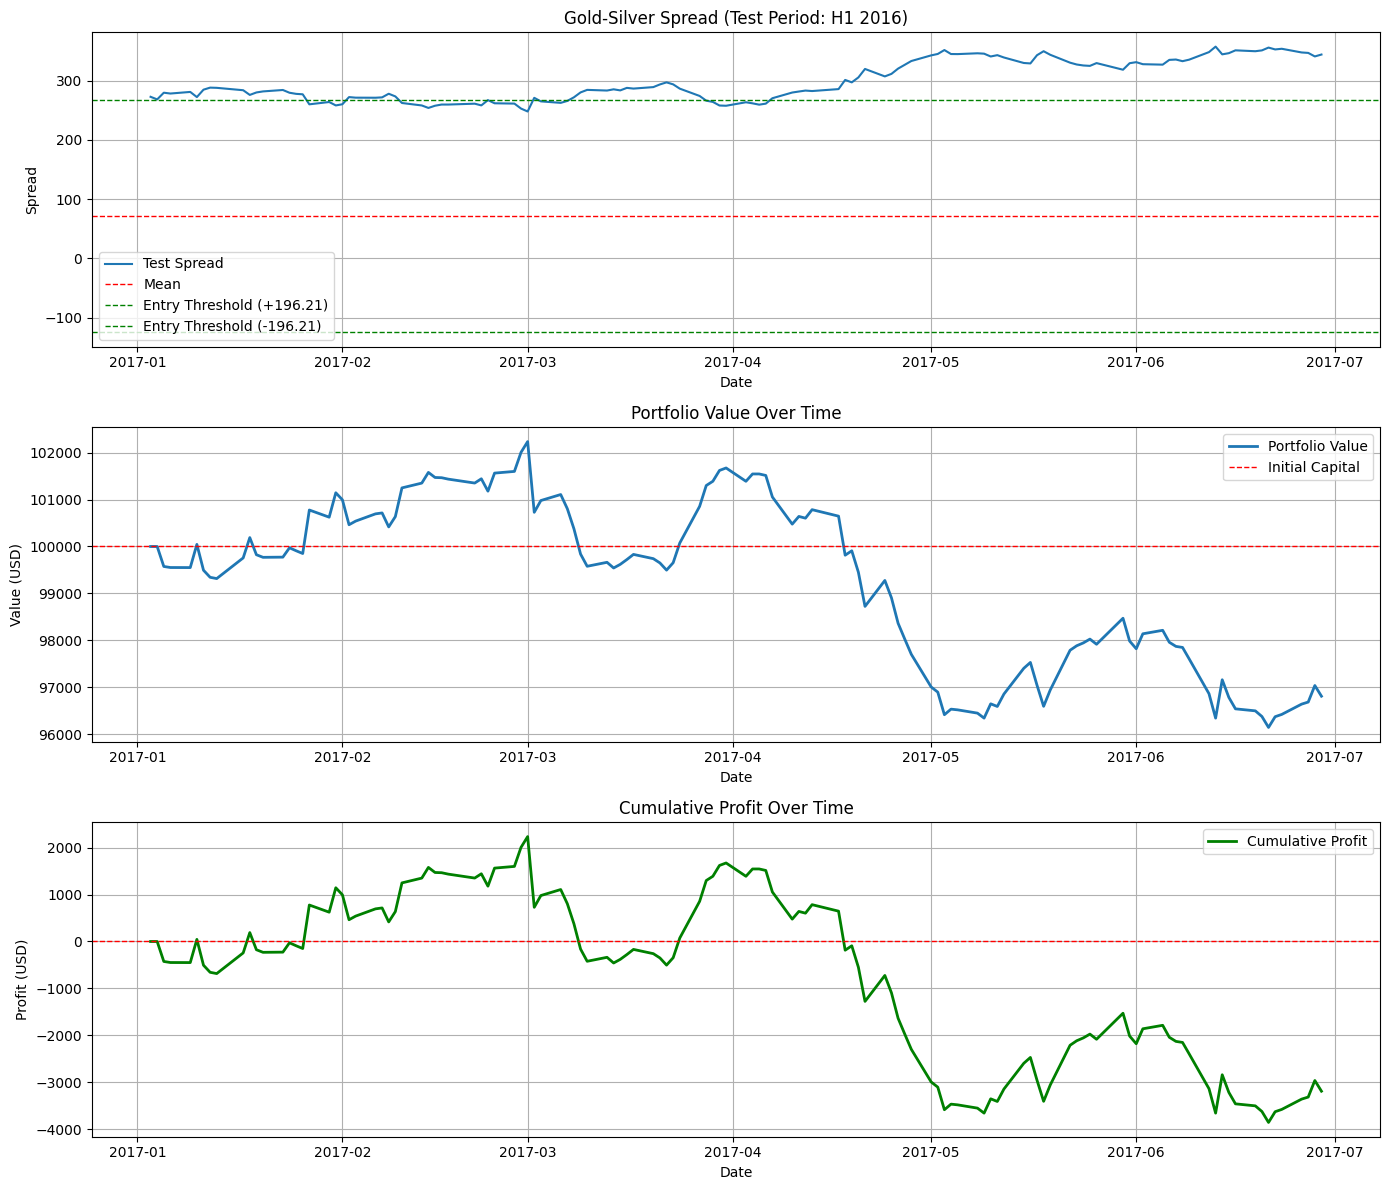


BACKTEST RESULTS - H1 2016
Initial Capital:        $100,000.00
Final Portfolio Value:  $96,809.45
Total Profit:           $-3,190.55
Total Return:           -3.19%
Sharpe Ratio:           -1.1044
Max Drawdown:           -5.96%
Number of Trading Days: 124


In [15]:
# Backtest on first half of 2016
gold_test = yf.download('GC=F', start='2017-01-01', end='2017-06-30')
silver_test = yf.download('SI=F', start='2017-01-01', end='2017-06-30')

# Initial capital
initial_capital = 100000
capital = initial_capital

# Calculate test spread
spread_test = gold_test[('Close', 'GC=F')] - silver_test[('Close', 'SI=F')]*k

# Trading parameters
entry_threshold = spread_std * 0.8  # Enter when spread is 1.5 std away from mean
exit_threshold = 0  # Exit when spread crosses mean

# Initialize positions and tracking
gold_position = pd.Series(0.0, index=spread_test.index)
silver_position = pd.Series(0.0, index=spread_test.index)
cash = pd.Series(capital, index=spread_test.index)
portfolio_value = pd.Series(capital, index=spread_test.index)

in_position = False
entry_spread = 0

for i, date in enumerate(spread_test.index):
    current_spread = spread_test.iloc[i]
    gold_price = gold_test[('Close', 'GC=F')].iloc[i]
    silver_price = silver_test[('Close', 'SI=F')].iloc[i]
    
    if i == 0:
        continue
    
    # Carry forward previous positions
    gold_position.iloc[i] = gold_position.iloc[i-1]
    silver_position.iloc[i] = silver_position.iloc[i-1]
    cash.iloc[i] = cash.iloc[i-1]
    
    # Update portfolio value
    portfolio_value.iloc[i] = cash.iloc[i] + \
                              gold_position.iloc[i] * gold_price + \
                              silver_position.iloc[i] * silver_price
    
    if not in_position:
        # Check for entry signals
        if current_spread > spread_mean + entry_threshold:
            # Spread is too high: short gold, long silver
            # Allocate 50% of portfolio value to each leg
            gold_value = -0.5 * portfolio_value.iloc[i]
            silver_value = 0.5 * portfolio_value.iloc[i]
            
            gold_position.iloc[i] = gold_value / gold_price
            silver_position.iloc[i] = silver_value / silver_price
            cash.iloc[i] = portfolio_value.iloc[i]  # Keep track (with margin)
            
            in_position = True
            entry_spread = current_spread
            
        elif current_spread < spread_mean - entry_threshold:
            # Spread is too low: long gold, short silver
            gold_value = 0.5 * portfolio_value.iloc[i]
            silver_value = -0.5 * portfolio_value.iloc[i]
            
            gold_position.iloc[i] = gold_value / gold_price
            silver_position.iloc[i] = silver_value / silver_price
            cash.iloc[i] = portfolio_value.iloc[i]  # Keep track (with margin)
            
            in_position = True
            entry_spread = current_spread
    else:
        # Check for exit signals (mean reversion)
        if (entry_spread > spread_mean and current_spread < spread_mean) or \
           (entry_spread < spread_mean and current_spread > spread_mean):
            # Exit position
            # Close positions and realize P&L
            cash.iloc[i] = portfolio_value.iloc[i]
            gold_position.iloc[i] = 0
            silver_position.iloc[i] = 0
            
            in_position = False

# Calculate daily returns and cumulative profit
daily_pnl = portfolio_value.diff().fillna(0)
cumulative_profit = portfolio_value - initial_capital

# Plot results
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Spread and trading signals
axes[0].plot(spread_test.index, spread_test, label='Test Spread', linewidth=1.5)
axes[0].axhline(y=spread_mean, color='r', linestyle='--', label='Mean', linewidth=1)
axes[0].axhline(y=spread_mean + entry_threshold, color='g', linestyle='--', 
                label=f'Entry Threshold (+{entry_threshold:.2f})', linewidth=1)
axes[0].axhline(y=spread_mean - entry_threshold, color='g', linestyle='--', 
                label=f'Entry Threshold (-{entry_threshold:.2f})', linewidth=1)
axes[0].set_title('Gold-Silver Spread (Test Period: H1 2016)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Spread')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Portfolio value
axes[1].plot(portfolio_value.index, portfolio_value, label='Portfolio Value', linewidth=2)
axes[1].axhline(y=initial_capital, color='r', linestyle='--', label='Initial Capital', linewidth=1)
axes[1].set_title('Portfolio Value Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value (USD)')
axes[1].legend()
axes[1].grid(True)

# Plot 3: Cumulative profit
axes[2].plot(cumulative_profit.index, cumulative_profit, label='Cumulative Profit', 
             linewidth=2, color='green')
axes[2].axhline(y=0, color='r', linestyle='--', linewidth=1)
axes[2].set_title('Cumulative Profit Over Time')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Profit (USD)')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Calculate performance metrics
final_value = portfolio_value.iloc[-1]
total_return = (final_value - initial_capital) / initial_capital * 100
total_profit = final_value - initial_capital

# Calculate Sharpe ratio (annualized)
daily_returns = portfolio_value.pct_change().dropna()
sharpe_ratio = np.sqrt(252) * daily_returns.mean() / daily_returns.std() if daily_returns.std() > 0 else 0

# Calculate maximum drawdown
running_max = portfolio_value.expanding().max()
drawdown = (portfolio_value - running_max) / running_max * 100
max_drawdown = drawdown.min()

print("\n" + "="*60)
print("BACKTEST RESULTS - H1 2016")
print("="*60)
print(f"Initial Capital:        ${initial_capital:,.2f}")
print(f"Final Portfolio Value:  ${final_value:,.2f}")
print(f"Total Profit:           ${total_profit:,.2f}")
print(f"Total Return:           {total_return:.2f}%")
print(f"Sharpe Ratio:           {sharpe_ratio:.4f}")
print(f"Max Drawdown:           {max_drawdown:.2f}%")
print(f"Number of Trading Days: {len(spread_test)}")
print("="*60)
